# Importing Necessary packages

In [1]:
# Import necessary libraries
import os # For path manipulation
import pandas as pd # For DataFrame manipulation
import numpy as np # For array manipulation

import seaborn as sns # For visualizing data
import matplotlib.pyplot as plt # For creating plots
import plotly.express as px # For creating interactive plots
import plotly.graph_objects as go # For creating interactive plots

import datetime as dt # For working with dates and times

from scipy.stats import iqr # For calculating interquartile range
from sklearn.preprocessing import StandardScaler # For scaling data
from sklearn.cluster import KMeans, OPTICS, DBSCAN # For clustering data
from sklearn.neighbors import NearestNeighbors # For finding nearest neighbors
from plotly.offline import iplot # For creating offline plotly plots
from plotly.subplots import make_subplots # For creating subplots in plotly


# Loading the data

In [2]:
# Set the path to the sales data file
data_path = os.path.join(os.getcwd(), 'data\sales_data_sample.csv')

# Read the sales data into a pandas dataframe
sales_data = pd.read_csv(data_path, encoding='iso-8859-1')

# Convert the 'ORDERDATE' column to a datetime format
sales_data['ORDERDATE'] = pd.to_datetime(sales_data['ORDERDATE'])

# Display the first five rows of the dataframe
sales_data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [3]:
# Call the info() method on the sales_data DataFrame to get a summary of its structure and contents
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

We can see in the above output that the DataFrame contains data about sales orders. The columns include information on the order number, quantity ordered, price each, order line number, sales, order date, order status, quarter ID, month ID, year ID, product line, MSRP, product code, customer name, phone number, address line 1 and 2, city, state, postal code, country, territory, contact last name, contact first name, and deal size. The data types of the columns include integers, floats, datetimes, and objects. Some columns have missing values, such as "address line 2", "state", "postal code", and "territory", but these columns are not defining for the segmentation of the clusters

# Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is an important step in any data analysis project. It involves the initial exploration and analysis of the data to identify patterns, trends, and relationships. EDA is often used to gain insights and to develop hypotheses about the data before applying more advanced statistical methods.

## Cleanning
Data cleaning is a crucial step in the exploratory data analysis process. It involves identifying and correcting errors, inconsistencies, and missing values in a dataset to ensure that it is accurate, complete, and usable for analysis. Data cleaning can involve tasks such as removing duplicates, filling missing values, correcting typos and formatting errors, and handling outliers. The goal of data cleaning is to ensure that the data is consistent and reliable, which is essential for making accurate inferences and drawing meaningful insights. By performing data cleaning, analysts can ensure that their analysis is based on high-quality data and that their conclusions are sound.

### Removing duplicated data

It's important verify if there are duplicated data to remove them from the dataset, but as can be seen in the following output there isn't any data duplicated.

In [4]:
# Verify if there are duplicated data
print(f"The total amount of duplicated data is: {sales_data.duplicated().sum()}")

The total amount of duplicated data is: 0


### Filtering the Sales Data by Shipped Status

The code below filters the `sales_data` DataFrame to only include rows where the 'STATUS' column is 'Shipped'.

The first line prints the unique values in the 'STATUS' column of the `sales_data` DataFrame. This is useful to check what values are present in the column before filtering.

The second line creates a new DataFrame called `sales_data` that only includes rows where the 'STATUS' column is 'Shipped'. This operation filters out all rows where the 'STATUS' column has a value other than 'Shipped'.

In order to verify that the operation was successful and to check the size and structure of the resulting DataFrame, the third line displays the resulting DataFrame after filtering. 

Filtering data is a common task in data analysis and can be useful to focus on specific subsets of the data. In this case, filtering by the 'Shipped' status can be useful to analyze only the orders that have been shipped, in order to do an accurate RFM analysis later.

In [5]:
# Print the unique values in the 'STATUS' column of the sales_data DataFrame
print(f"STATUS = {sales_data['STATUS'].unique()}")

# Filter the sales_data DataFrame to only include rows where the 'STATUS' column is 'Shipped'
sales_data = sales_data[sales_data['STATUS'] == "Shipped"]

# Show the resulting DataFrame after filtering
sales_data

STATUS = ['Shipped' 'Disputed' 'In Process' 'Cancelled' 'On Hold' 'Resolved']


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,10315,40,55.69,5,2227.60,2004-10-29,Shipped,4,10,2004,...,"67, rue des Cinquante Otages",NaN,Nantes,NaN,44000,France,EMEA,Labrune,Janine,Small
2817,10337,42,97.16,5,4080.72,2004-11-21,Shipped,4,11,2004,...,5905 Pompton St.,Suite 750,NYC,NY,10022,USA,NaN,Hernandez,Maria,Medium
2818,10350,20,100.00,15,2244.40,2004-12-02,Shipped,4,12,2004,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,2005-01-31,Shipped,1,1,2005,...,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium


## Univariate analysis
Univariate analysis is a statistical method used to analyze a single variable in a dataset. It is a common first step in data analysis and is used to explore the distribution of a variable, identify outliers, and summarize its central tendency and variability. Univariate analysis can be performed using various techniques, such as histograms.


The first line of the following cell uses the Seaborn library to plot a histogram of the 'PRICEEACH' column in the `sales_data` DataFrame. The `x` parameter specifies which column to use for the x-axis, and the `bins` parameter specifies the bin edges for the histogram.

The second line uses the `plt.title()` function from the Matplotlib library to add a title to the plot.

The third line uses the `plt.show()` function from the Matplotlib library to display the plot.

Histograms are a useful visualization technique for exploring the distribution of a numerical variable in a dataset. In this case, the histogram shows the distribution of the price of each product sold in the `sales_data` DataFrame. The bin edges are specified as a list of integers that range from 10 to 100 in increments of 10.

As can be seen in the following histogram the largest number of products sold is in the price range of 90-100.

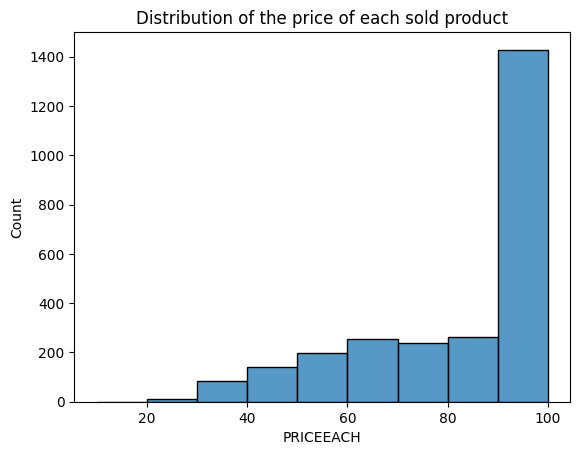

In [6]:
# Plot a histogram of the 'PRICEEACH' column in the sales_data DataFrame
sns.histplot(data=sales_data, x="PRICEEACH", bins=list(range(10,110,10)))

# Add a title to the plot
plt.title("Distribution of the price of each sold product")

# Show the plot
plt.show()

The first line of the following cell uses the Seaborn library to plot a histogram of the 'SALES' column in the `sales_data` DataFrame. The `x` parameter specifies which column to use for the x-axis.

The second line uses the `plt.title()` function from the Matplotlib library to add a title to the plot.

The third line uses the `plt.show()` function from the Matplotlib library to display the plot.

Histograms are a useful visualization technique for exploring the distribution of a numerical variable in a dataset. In this case, the histogram shows the distribution of the `SALES` column in the `sales_data` DataFrame. 

As can be seen in the following output the largest number of sales is in the range of 1727-5374(mean +- std)

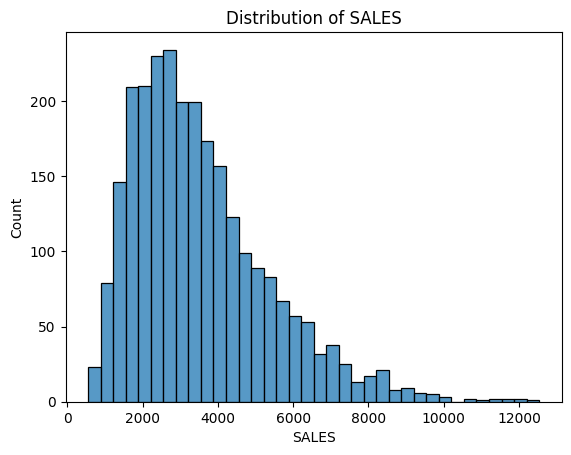

mean of sales: 			 3550.439847153229 
standard deviation of sales:	 1823.5191496063364
The largest number of sales is in the range of 1727-5374 (mean +- std)


In [7]:
# Plot a histogram of the 'DEALSIZE' column in the sales_data DataFrame
sns.histplot(data=sales_data, x="SALES")

# Add a title to the plot
plt.title("Distribution of SALES")

# Show the plot
plt.show()

# Calculating the mean of sales
mean = sales_data['SALES'].mean()

# Calculating the standard deviation of the sales
std = sales_data['SALES'].std()

# Print the mean and the standard deviation of sales
print(f"mean of sales: \t\t\t {mean} \nstandard deviation of sales:\t {std}")
print(f"The largest number of sales is in the range of {(mean-std).__round__()}-{(mean+std).__round__()} (mean +- std)")



The first line of the following cell uses the Seaborn library to plot a histogram of the 'PRODUCTLINE' column in the `sales_data` DataFrame. The `x` parameter specifies which column to use for the x-axis.

The second line uses the `plt.title()` function from the Matplotlib library to add a title to the plot.

The third line uses the `plt.xticks()` function from the Matplotlib library to rotate the x-axis labels by 45 degrees and reduce their font size to 10.

The fourth line uses the `plt.show()` function from the Matplotlib library to display the plot.

The histogram shows the distribution of the `PRODUCTLINE` column in the `sales_data` DataFrame. The resulting plot can help identify which product lines are most popular among customers.

As can be seen in the following output the most popular product are the classic cars, followed by vintage cars. Motorcycles, planes, truck and buses have a similar demand. The trains are in a low demand

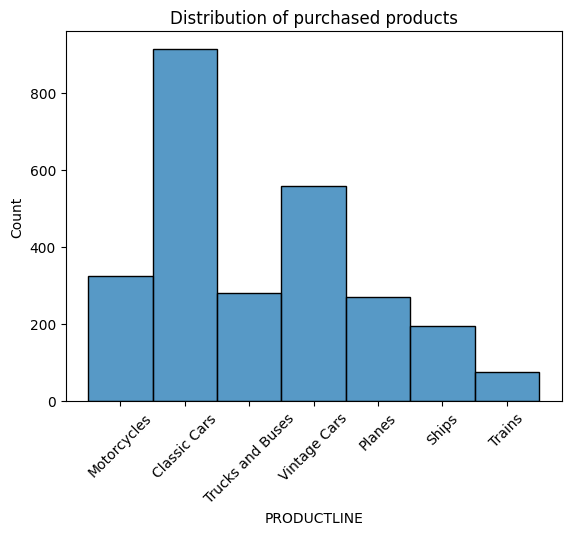

In [8]:
# Plot a histogram of the 'PRODUCTLINE' column in the sales_data DataFrame
sns.histplot(data=sales_data, x="PRODUCTLINE")

# Add a title to the plot
plt.title("Distribution of purchased products")

# Rotate the x-axis labels by 45 degrees and reduce font size to 10
plt.xticks(rotation=45, fontsize=10)

# Show the plot
plt.show()

The first line of the following cell group the sales_data DataFrame by country and count the number of orders for each country.

The second line renames the 'ORDERNUMBER' column to 'ORDERSCOUNTS' to make the column name more descriptive.

The third line uses the Plotly Express library to create a choropleth map of the total order counts by country. The `locations` parameter specifies the column in the DataFrame to use for the map's regions, and the `color` parameter specifies the column in the DataFrame to use for the map's colors. The `hover_name` parameter specifies the column in the DataFrame to use for the hover-over labels, and the `projection` parameter specifies the map projection to use. Finally, the `title` parameter specifies the title of the plot.

The fourth line shows the resulting choropleth map using the `fig.show()` method.

The fifth line sort the grouped_data DataFrame by the 'ORDERSCOUNTS' column in descending order and displays the result. In the table marketing team can visualize in descening order the countries with highest number of orders and take decisions.

Choropleth maps are a useful visualization technique for exploring geographic data, such as the distribution of sales or orders by country or region. The resulting map can help identify which countries or regions have the highest or lowest number of orders, and can inform decisions related to sales and marketing strategies.

As can be seen in the following output, the USA is by far the country with the largest amount of purchases, while Ireland is the country with the least amount of purchases.


In [9]:
# Group the sales_data DataFrame by country and count the number of orders for each country
grouped_data = sales_data[["ORDERNUMBER", "COUNTRY"]].groupby('COUNTRY').count().reset_index()

# Rename the 'ORDERNUMBER' column to 'ORDERSCOUNTS'
grouped_data.rename(columns={"ORDERNUMBER": "ORDERSCOUNTS"}, inplace=True)

# Create the choropleth map
fig = px.choropleth(grouped_data, locations='COUNTRY', color='ORDERSCOUNTS',
                    locationmode="country names",
                    hover_name='COUNTRY', projection='natural earth',
                    title='Total Order Counts by Country')

# Show the plot
fig.show()

# Sort the grouped_data DataFrame by the 'ORDERSCOUNTS' column in descending order and reset the index to start from 0
grouped_data.sort_values(by="ORDERSCOUNTS", ascending=False).reset_index(drop=True)

,COUNTRY,ORDERSCOUNTS
0,USA,935
1,France,301
2,Spain,296
3,Australia,167
4,UK,130
5,Italy,113
6,Finland,92
7,Norway,85
8,Singapore,79
9,Canada,70


In addition to the map, you can also view the distribution of purchases by country in a histogram.


The first line of the following code uses the Seaborn library to plot a histogram of the 'COUNTRY' column in the `sales_data` DataFrame. The `x` parameter specifies which column to use for the x-axis.

The second line uses the `plt.title()` function from the Matplotlib library to add a title to the plot.

The third line uses the `plt.xticks()` function from the Matplotlib library to rotate the x-axis labels by 90 degrees and reduce their font size to 6.

The fourth line uses the `plt.show()` function from the Matplotlib library to display the plot.

Histograms are a useful visualization technique for exploring the distribution of a categorical variable in a dataset. In this case, the histogram shows the distribution of the 'COUNTRY' column in the `sales_data` DataFrame. The resulting plot can help identify which countries have the highest or lowest number of purchased, and can inform decisions related to sales and marketing strategies.

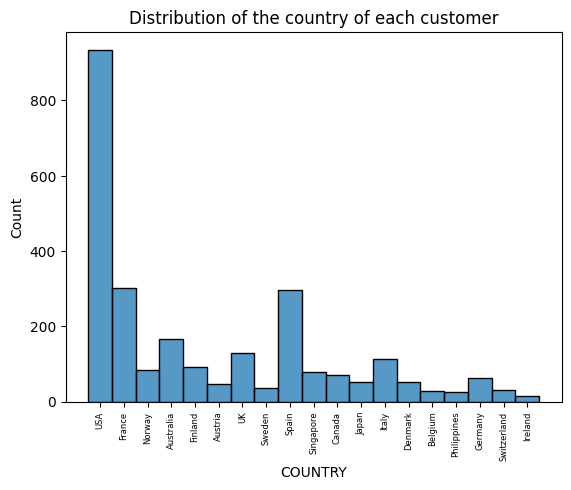

In [10]:
# Plot a histogram of the 'COUNTRY' column in the sales_data DataFrame
sns.histplot(data=sales_data, x="COUNTRY")

# Add a title to the plot
plt.title("Distribution of the country of each customer")

# Rotate the x-axis labels by 90 degrees and reduce font size to 6
plt.xticks(rotation=90, fontsize=6)

# Show the plot
plt.show()

The first line of the following cell uses the Seaborn library to plot a histogram of the 'CITY' column in the `sales_data` DataFrame. The `x` parameter specifies which column to use for the x-axis.

The second line uses the `plt.title()` function from the Matplotlib library to add a title to the plot.

The third line uses the `plt.xticks()` function from the Matplotlib library to rotate the x-axis labels by 90 degrees and reduce their font size to 6.

The fourth line uses the `plt.show()` function from the Matplotlib library to display the plot.

Histograms are a useful visualization technique for exploring the distribution of a categorical variable in a dataset. In this case, the histogram shows the distribution of the 'CITY' column in the `sales_data` DataFrame. The resulting plot can help identify which cities have the highest or lowest number of customers, and can inform decisions related to sales and marketing strategies.

As can be seen Madrid is the city with the largest amount of purchased, followed by San Rafael; while Newark, Graz and Charleroi are the cities with lowest amount of purchases.

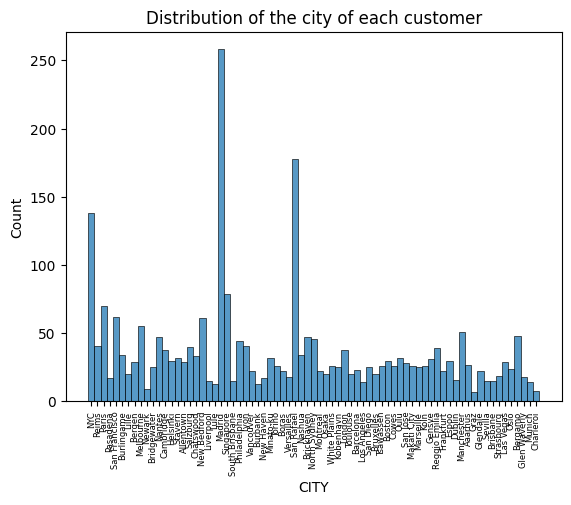

In [11]:
# Plot a histogram of the 'CITY' column in the sales_data DataFrame
sns.histplot(data=sales_data, x="CITY")

# Add a title to the plot
plt.title("Distribution of the city of each customer")

# Rotate the x-axis labels by 90 degrees and reduce font size to 6
plt.xticks(rotation=90, fontsize=6)

# Show the plot
plt.show()

## Preprocessing
There are 3 new DataFrames that can be obtained from the `sales_data`: 
- `customer_df`: Contains information of interest of each customer. Has one row for each unique customer and includes data such as the customer's country, city, phone number, last name, and first name. The customer DataFrame will be useful for further analysis of customer behavior and preferences.

- `product_line_df`: The resulting DataFrame has one row for each unique customer and includes data on the quantity of orders for each product line.

- `rfm_df`: The DataFrame is created to perform an RFM analysis, which is a technique used in marketing to analyze customer behavior based on three metrics: recency, frequency, and monetary value. The DataFrame is created by first calculating the recency, frequency, and monetary value for each customer in the `sales_data` DataFrame. Also is added another column `QUANTITYORDERED_last_year`, characteristic that gives the meassurement of the total quantity ordered in the last year by each customer. These four columns can be used to identify patterns in the customers.

### Creating the Customer DataFrame 

The following code uses the `groupby()` method from the `pandas` library to group the `data` DataFrame by `CUSTOMERNAME`, and then applies an aggregation function to each group to create a new DataFrame called `customer_df`, this DataFrame contains information of interest of each customer.

The aggregation function uses a dictionary to specify the columns to include in `customer_df` and the corresponding function to apply to each column. In this case, the function used for each column is a lambda function that extracts the first value of the column (using the `to_list()` method) or the unique values of the `PRODUCTLINE` column (using the `unique()` method).

Here's the resulting DataFrame:

```python
customer_df

In [12]:
customer_df = sales_data.groupby(by='CUSTOMERNAME').agg({"COUNTRY": lambda var: var.to_list()[0],
                                                   "CITY": lambda var: var.to_list()[0],
                                                   "PHONE": lambda var: var.to_list()[0],
                                                   "CONTACTLASTNAME": lambda var: var.to_list()[0],
                                                   "CONTACTFIRSTNAME": lambda var: var.to_list()[0],
                                                #    "PRODUCTLINE": lambda var: var.unique()
                                                  })

customer_df["Customer_ID"] = np.arange(1, len(customer_df)+1)

customer_df

,COUNTRY,CITY,PHONE,CONTACTLASTNAME,CONTACTFIRSTNAME,Customer_ID
CUSTOMERNAME,,,,,,
"AV Stores, Co.",UK,Manchester,(171) 555-1555,Ashworth,Victoria,1
Alpha Cognac,France,Toulouse,61.77.6555,Roulet,Annette,2
Amica Models & Co.,Italy,Torino,011-4988555,Accorti,Paolo,3
"Anna's Decorations, Ltd",Australia,North Sydney,02 9936 8555,O'Hara,Anna,4
Atelier graphique,France,Nantes,40.32.2555,Schmitt,Carine,5
...,...,...,...,...,...,...
"Vida Sport, Ltd",Switzerland,Gensve,0897-034555,Holz,Michael,88
Vitachrome Inc.,USA,NYC,2125551500,Frick,Michael,89
"Volvo Model Replicas, Co",Sweden,Lule,0921-12 3555,Berglund,Christina,90


### Creating the Product Line DataFrame

The code below creates a new DataFrame called `product_line_df` by grouping the `sales_data` DataFrame by customer name and product line, and aggregating the data.

The first line creates a new DataFrame called `product_line_df` with an index of customer names and columns of unique product lines from the `sales_data` DataFrame.

The `groupby()` method is used to group the `sales_data` DataFrame by customer name. This creates a new DataFrame where each row represents a unique customer.

The `for` loop iterates over each customer and product in the `product_line_df` DataFrame. For each product, the code sums the quantity of orders for that product made by the customer. This is done by filtering the `columns` DataFrame to only include rows where the 'PRODUCTLINE' column matches the current product, and then summing the 'QUANTITYORDERED' column.

The resulting `product_line_df` DataFrame has one row for each unique customer and includes data on the quantity of orders for each product line.

Creating a product line DataFrame can be useful for further analysis of which product lines are most popular among customers. This can help inform decisions related to product development and marketing strategies.

In [13]:
# Create a new DataFrame called product_line_df with an index of customer names and columns of unique product lines from the sales_data DataFrame
product_line_df = pd.DataFrame(index=customer_df.index, columns=sales_data["PRODUCTLINE"].unique())

# Group the sales_data DataFrame by customer name
customer_group = sales_data.groupby(by='CUSTOMERNAME')

# Iterate over each customer
for customer_name, columns in customer_group:
    # Iterate over each product in the product_line_df DataFrame
    for product in product_line_df.columns.values:
        # Sum the quantity of orders for the current product made by the customer
        product_line_df.loc[customer_name, product] = columns[columns["PRODUCTLINE"] == product]["QUANTITYORDERED"].sum()

# Show the resulting DataFrame
product_line_df


,Motorcycles,Classic Cars,Trucks and Buses,Vintage Cars,Planes,Ships,Trains
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",0,628,0,773,0,257,120
Alpha Cognac,0,126,0,96,218,247,0
Amica Models & Co.,0,149,24,566,0,82,22
"Anna's Decorations, Ltd",219,744,286,220,0,0,0
Atelier graphique,71,156,0,43,0,0,0
...,...,...,...,...,...,...,...
"Vida Sport, Ltd",0,1078,0,0,0,0,0
Vitachrome Inc.,239,239,158,151,0,0,0
"Volvo Model Replicas, Co",0,184,0,134,0,80,32


### RFM Analysis

RFM analysis is a marketing technique used to analyze customer behavior based on three metrics: recency, frequency, and monetary value. Recency refers to the time since a customer's last purchase, frequency refers to the number of purchases made by a customer, and monetary value refers to the total amount of money spent by a customer.

RFM analysis can be used to segment customers based on their behavior and to identify high-value customers who are more likely to make repeat purchases or to spend more money. By grouping customers based on these metrics, marketers can tailor their marketing strategies to better meet the needs of each customer segment.

For example, customers who have made a purchase recently and frequently, and who have spent a large amount of money, may be considered high-value customers and may receive special offers or discounts to reward their loyalty. Customers who have not made a purchase in a long time may be targeted with special promotions to encourage them to return.

RFM analysis can provide insights into customer behavior that can inform marketing strategies, improve customer engagement, and increase revenue. It is a valuable tool for businesses looking to understand their customers better and to develop targeted marketing campaigns.

As the data is very old, the RFM analysis will work under the assumption that the current date is the date on which the last sale was made, so the actual year is 2005 and the last year for the frequency and monetary characteristics is 2004.
The following code is computing the recency, frequency, and monetary value for each customer using the following steps:

1. The `last_order_date` variable is set to the maximum value of the `ORDERDATE` column in the `data` DataFrame, which represents the date of the last order in the dataset.

2. The `current_date` variable is set to the same value as `last_order_date`, which assumes that the current date is the date on which the last sale was made.

3. The `last_year` variable is calculated as one year ago from the `current_date`, which is used to filter the data for the last year of sales in the dataset.

4. Three new columns are created in the `data` DataFrame: `RECENCY_days`, `FREQUENCY_last_year`, and `MONETARY_last_year`. These columns will be used to store the recency, frequency, and monetary value for each customer, respectively.

5. The `recency_quantity` variable is created by grouping the `data` DataFrame by `CUSTOMERNAME` and applying a lambda function to the `ORDERDATE` column that calculates the number of days between the `current_date` and the maximum order date for each customer(this says how long it has been since the customer placed their last order). This results in a DataFrame that contains the recency value for each customer.

6. The `frecuency_monetary_ordered_last_year` variable is created by filtering the `data` DataFrame to include only the rows where the `ORDERDATE` is greater than or equal to `last_year`, grouping the resulting DataFrame by `CUSTOMERNAME`, and applying a lambda function to three columns: `FREQUENCY_last_year`, `MONETARY_last_year`, and `QUANTITYORDERED`. The `FREQUENCY_last_year` column is used to calculate the frequency of orders (i.e., the number of unique order numbers), the `MONETARY_last_year` column is used to calculate the monetary value of orders (i.e., the sum of sales), and the `QUANTITYORDERED` column is used to calculate the total quantity ordered in the last year.

7. The `recency_quantity` and `frecuency_monetary_ordered_last_year` DataFrames are concatenated along the column axis using `pd.concat()` to create a new DataFrame called `rfm_data`. This DataFrame contains the recency, frequency, monetary value, and quantity ordered data for each customer.

8. Any missing values in `rfm_data` are filled with 0 using the `fillna()` method. The missing values ​​are the product of the fact that some clients have not placed orders in the last year.

The result of this cell is a DataFrame containning the RFM analysis of the data plus the `QUANTITYORDERED` characteristic that gives the meassurement of the total quantity ordered in the last year by each customer

In [14]:
# Getting the last order date from the 'data' DataFrame
last_order_date: dt.datetime = max(sales_data["ORDERDATE"])

# Assuming that the current date is the date on which the last sale was made
current_date: dt.datetime = last_order_date

# Calculating the date that was one year ago from the current date, this date will be used to filter the data from the current date to the last year to analyze the RFM
last_year = current_date - dt.timedelta(days=365)

# Creating new columns in the 'data' DataFrame for the RFM analysis
sales_data["RECENCY_days"] = sales_data["ORDERDATE"].copy() 
sales_data["FREQUENCY_last_year"] = sales_data["ORDERNUMBER"].copy()
sales_data["MONETARY_last_year"] = sales_data["SALES"].copy()

# Calculating the recency for each customer
recency_quantity = sales_data.groupby(by='CUSTOMERNAME').agg({"RECENCY_days": lambda order_dates: (current_date - order_dates.max()).days})

# Calculating the frequency, monetary value, and quantity ordered in the last year for each customer
frecuency_monetary_ordered_last_year = sales_data[sales_data["ORDERDATE"] >= last_year].groupby('CUSTOMERNAME').agg({"FREQUENCY_last_year": lambda order_number: len(order_number.unique()),
                                                                                                         "MONETARY_last_year": lambda sales: sales.sum(),
                                                                                                         "QUANTITYORDERED": lambda quantity: int(quantity.sum())})

# Renaming the 'QUANTITYORDERED' column to 'QUANTITYORDERED_last_year'
frecuency_monetary_ordered_last_year.rename(columns={"QUANTITYORDERED": "QUANTITYORDERED_last_year"}, inplace=True)

# Concatenating the recency, frequency, monetary, and quantity data into a single DataFrame for the RFM analysis
rfm_df = pd.concat([recency_quantity, frecuency_monetary_ordered_last_year], axis=1)

# Filling any missing values with 0
rfm_df.fillna(0, inplace=True)
rfm_df

,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,QUANTITYORDERED_last_year
CUSTOMERNAME,,,,
"AV Stores, Co.",181,2.0,106789.89,1208.0
Alpha Cognac,50,1.0,15139.12,172.0
Amica Models & Co.,250,2.0,94117.26,843.0
"Anna's Decorations, Ltd",69,2.0,65012.42,595.0
Atelier graphique,173,2.0,7619.66,114.0
...,...,...,...,...
"Vida Sport, Ltd",260,1.0,67281.01,595.0
Vitachrome Inc.,193,1.0,56372.87,468.0
"Volvo Model Replicas, Co",189,2.0,39745.67,378.0


### Concatenating the rfm_df and product_line_df with the customer_df

The following line of code concatenates three DataFrames (`rfm_df`, `customer_df`, and `product_line_df`) into a single DataFrame called `customer_df`. The `concat()` function from the Pandas library is used to concatenate the DataFrames along the columns (`axis=1`).


In [15]:
# Concatenating the rfm_df, customer_df, and product_line_df DataFrames into a single DataFrame
customer_df = pd.concat([rfm_df, customer_df, product_line_df], axis=1)
customer_df


,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,QUANTITYORDERED_last_year,COUNTRY,CITY,PHONE,CONTACTLASTNAME,CONTACTFIRSTNAME,Customer_ID,Motorcycles,Classic Cars,Trucks and Buses,Vintage Cars,Planes,Ships,Trains
CUSTOMERNAME,,,,,,,,,,,,,,,,,
"AV Stores, Co.",181,2.0,106789.89,1208.0,UK,Manchester,(171) 555-1555,Ashworth,Victoria,1,0,628,0,773,0,257,120
Alpha Cognac,50,1.0,15139.12,172.0,France,Toulouse,61.77.6555,Roulet,Annette,2,0,126,0,96,218,247,0
Amica Models & Co.,250,2.0,94117.26,843.0,Italy,Torino,011-4988555,Accorti,Paolo,3,0,149,24,566,0,82,22
"Anna's Decorations, Ltd",69,2.0,65012.42,595.0,Australia,North Sydney,02 9936 8555,O'Hara,Anna,4,219,744,286,220,0,0,0
Atelier graphique,173,2.0,7619.66,114.0,France,Nantes,40.32.2555,Schmitt,Carine,5,71,156,0,43,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Vida Sport, Ltd",260,1.0,67281.01,595.0,Switzerland,Gensve,0897-034555,Holz,Michael,88,0,1078,0,0,0,0,0
Vitachrome Inc.,193,1.0,56372.87,468.0,USA,NYC,2125551500,Frick,Michael,89,239,239,158,151,0,0,0
"Volvo Model Replicas, Co",189,2.0,39745.67,378.0,Sweden,Lule,0921-12 3555,Berglund,Christina,90,0,184,0,134,0,80,32


## Bivariate Analysis
Bivariate analysis entails determining the correlation between two features.

Let's check the relationship between the Recency and the Frequency.

This code creates a scatter plot using the `px.scatter()` function from the Plotly Express library. The scatter plot visualizes the relationship between the recency and frequency of customer purchases. The `data_frame` parameter specifies the DataFrame (`customer_df`) to use for the plot, while the `x` and `y` parameters specify which columns to use for the x-axis and y-axis, respectively (`RECENCY_days` and `FREQUENCY_last_year`).

The `title` parameter is used to add a title to the plot. The `height` parameter specifies the height of the plot in pixels.

The `color` parameter is used to add color encoding to the plot based on the `COUNTRY` column in `customer_df`. 

The `fig.show()` function is used to display the plot.

Scatter plots are useful for visualizing the relationship between two variables. In this case, the plot shows how the recency and frequency of customer purchases are related. This information can be used to identify customer segments with different purchasing behaviors and inform marketing strategies. 

In the following picture we can see that customers that have less Frequency (amount of orders in the last year) have a higher value of Recency (time since the last purchased). Also can be seen that 3 groups of customers: 

1- Conformed by 2 customers with high frequency an low recency.

2- Conformed by 12 customers with 0 frequency in the last year.

3- A mix group.

Another observation is that the color that the most abundant color is orange, this is due to what was previously analyzed that the USA is the country with the largest purchases and customers.

In [16]:
# Creating a scatter plot using the Plotly Express library
fig = px.scatter(
    data_frame=customer_df,
    x = "RECENCY_days",
    y= "FREQUENCY_last_year",
    title = "Relationship between RECENCY VS FREQUENCY",
    color = "COUNTRY",
    height=500
)
# Displaying the plot
fig.show()

Let's check the relationship between the Recency and Monetary

This code creates a scatter plot using the `px.scatter()` function from the Plotly Express library. The scatter plot visualizes the relationship between the recency and monetary value of customer purchases, with each data point colored based on the country of the customer. The `data_frame` parameter specifies the DataFrame (`customer_df`) to use for the plot, while the `x` and `y` parameters specify which columns to use for the x-axis and y-axis, respectively (`RECENCY_days` and `MONETARY_last_year`).

The `title` parameter is used to add a title to the plot. The `color` parameter is used to add color encoding to the plot based on the `COUNTRY` column in `customer_df`. The `height` parameter specifies the height of the plot in pixels.

The `fig.show()` function is used to display the plot.

This scatter plot can help identify trends or patterns in customer behavior related to the recency and monetary value of purchases. For example, it may reveal that customers who have made purchases recently and have spent more money are more likely to be high-value customers who are more likely to make repeat purchases. By identifying these trends, businesses can develop targeted marketing strategies to better engage and retain customers.

Can be seen the same 3 groups than before, It remains difficult to separate the mixed group.

In [17]:
# Creating a scatter plot using the Plotly Express library
fig = px.scatter(
    data_frame=customer_df,
    x = "RECENCY_days",
    y= "MONETARY_last_year",
    title = "Relationship between RECENCY VS MONETARY",
    color = "COUNTRY",
    height=500
)
# Displaying the plot
fig.show()

Let's check the relationship between the QUANTITYORDERED and Monetary

This code creates a scatter plot using the `px.scatter()` function from the Plotly Express library. The scatter plot visualizes the relationship between the quantity of items ordered and the monetary value of customer purchases, with each data point colored based on the country of the customer. The `data_frame` parameter specifies the DataFrame (`customer_df`) to use for the plot, while the `x` and `y` parameters specify which columns to use for the x-axis and y-axis, respectively (`QUANTITYORDERED_last_year` and `MONETARY_last_year`).

The `title` parameter is used to add a title to the plot. The `color` parameter is used to add color encoding to the plot based on the `COUNTRY` column in `customer_df`. The `height` parameter specifies the height of the plot in pixels.

The `fig.show()` function is used to display the plot.

This scatter plot can help identify trends or patterns in customer behavior related to the quantity and monetary value of purchases. For example, it may reveal that customers who have ordered a large quantity of items and have spent more money are more likely to be high-value customers who are more likely to make repeat purchases. By identifying these trends, businesses can develop targeted marketing strategies to better engage and retain customers. 

As can be seen in the following picture the features `QUANTITYORDERED_last_year` and `MONETARY_last_year` have a linear relationship. 

No pattern to the naked eye is observed with the country.

In [18]:
# Creating a scatter plot using the Plotly Express library
fig = px.scatter(
    data_frame=customer_df,
    x = "QUANTITYORDERED_last_year",
    y= "MONETARY_last_year",
    title = "Relationship between QUANTITYORDERED VS MONETARY",
    color = "COUNTRY",
    height=500
)
# Displaying the plot
fig.show()

Let's check the relationship between the FREQUENCY and Monetary

This code creates a scatter plot using the `px.scatter()` function from the Plotly Express library. The scatter plot visualizes the relationship between the frequency of purchases and the monetary value of customer purchases, with each data point colored based on the country of the customer. The `data_frame` parameter specifies the DataFrame (`customer_df`) to use for the plot, while the `x` and `y` parameters specify which columns to use for the x-axis and y-axis, respectively (`FREQUENCY_last_year` and `MONETARY_last_year`).

The `title` parameter is used to add a title to the plot. The `color` parameter is used to add color encoding to the plot based on the `COUNTRY` column in `customer_df`. The `height` parameter specifies the height of the plot in pixels.

The `fig.show()` function is used to display the plot.

This scatter plot can help identify trends or patterns in customer behavior related to the frequency and monetary value of purchases. For example, it may reveal that customers who make frequent purchases and have spent more money are more likely to be high-value customers who are more likely to make repeat purchases. By identifying these trends, businesses can develop targeted marketing strategies to better engage and retain customers.

In the following picture can be seen that generally customers who buy more frequently invest a greater amount of money in the year.

In [19]:
# Creating a scatter plot using the Plotly Express library
fig = px.scatter(
    data_frame=customer_df,
    x = "FREQUENCY_last_year",
    y= "MONETARY_last_year",
    title = "Relationship between FREQUENCY VS MONETARY",
    color = "COUNTRY",
    height=500
)
# Displaying the plot
fig.show()

# The Segmentation Model
In a customer segmentation project, the segmentation model is a crucial part of the process. The goal of the model is to group customers into segments based on common characteristics. 


## Scaling
The following cell uses the `StandardScaler()` function from the scikit-learn library to scale the RFM data. Scaling the data is an important step in many data analysis projects, as it helps to ensure that all variables are on the same scale and have the same level of influence in the analysis.

The `StandardScaler()` function standardizes the data by subtracting the mean and dividing by the standard deviation. This results in data that has a mean of 0 and a standard deviation of 1. 

The `fit_transform()` method is used to apply the scaling transformation to the RFM data. The resulting scaled data is then used to create a new DataFrame, `rfm_df_scaled`, containing the scaled values for the four RFM variables.

In [20]:
# Scaling the RFM Data using StandardScaler from scikit-learn
std_scaler = StandardScaler()

# Creating a scaled array of the RFM data
rfm_array_scaled = std_scaler.fit_transform(rfm_df.iloc[:,0:4]) 

# Creating a DataFrame of the scaled RFM data
rfm_df_scaled = pd.DataFrame(rfm_array_scaled, columns=rfm_df.columns[0:4])


## KMeans Algorithm

### Method Explanation: 

This code uses the elbow method to determine the optimal number of clusters for a KMeans clustering algorithm. The elbow method involves plotting the error (inertia) as a function of the number of clusters, and selecting the number of clusters at the "elbow" of the curve, where the decrease in error begins to level off.

To compute the inertia for a KMeans clustering algorithm, the following steps are typically taken:

1. Initialize k centroids randomly
2. Assign each data point to the nearest centroid
3. Compute the new centroid for each cluster
4. Repeat steps 2 and 3 until convergence is reached

The inertia of a cluster is calculated as the sum of the squared distances between each data point and its assigned centroid. Therefore, the total inertia of a clustering solution is the sum of the inertia of each cluster.

To apply the elbow method, the KMeans algorithm is applied to the data for a range of k values. For each k value, the inertia is calculated and stored in a list. A plot is then created of the inertia as a function of k. The plot typically shows a decreasing trend in inertia as k increases, as adding more clusters will always reduce the inertia. However, the rate of decrease in inertia will typically decrease as k increases, resulting in a curve that begins to level off at some point. The optimal number of clusters is typically selected as the k value at the "elbow" of the curve, where the decrease in inertia begins to level off.

The elbow method is a useful technique for determining the optimal number of clusters in unsupervised machine learning applications. It can help avoid overfitting (using too many clusters) or underfitting (using too few clusters) the data, and can lead to more accurate and effective clustering solutions.

### Code Explanation:

The `errors` list is initialized as an empty list, and a loop is used to fit the KMeans clustering algorithm to the scaled RFM data for k values ranging from 1 to 10. The error (inertia) for each k value is then appended to the `errors` list.

A plot is then created using the Seaborn `pointplot()` function to visualize the errors as a function of k. The resulting plot can help identify the optimal number of clusters for the KMeans algorithm.

As can be seen in the plot the the decrease in error begins to level off for k=3 or k=4. Both values were tested and the best result was with k=4.

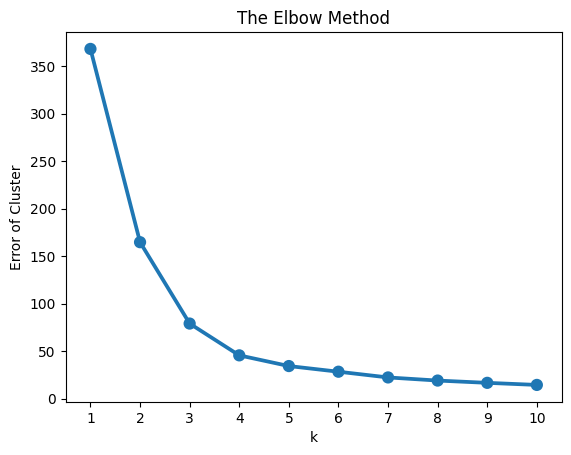

In [21]:
# Finding the optimal number of clusters using the elbow method
errors = []

# Looping through k values from 1 to 10
for k in range(1, 11):
    # Creating a KMeans clustering object with k clusters
    kmeans_clustering = KMeans(n_clusters=k, random_state=42)
    
    # Fitting the clustering object to the scaled RFM data
    kmeans_clustering.fit(rfm_array_scaled)
    
    # Appending the error (inertia) to the errors list
    errors.append(kmeans_clustering.inertia_)
    
# Plotting the errors as a function of k
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('Error of Cluster')
sns.pointplot(x=np.arange(start=1, stop=11), y=errors)
plt.show()

This code applies the KMeans clustering algorithm to the scaled RFM data, using `n_clusters=4` to specify that the data should be clustered into four distinct groups. The `random_state=42` parameter is used for reproducibility, so that the results can be replicated exactly.

After fitting the clustering object to the scaled RFM data, the resulting cluster labels are assigned to the original `customer_df` DataFrame using the `assign()` method. The new column `KMeansLabel` contains the assigned cluster label for each customer.

Finally, the updated `customer_df` DataFrame is displayed, showing the original customer data along with the assigned KMeans cluster labels.

In [22]:
# Creating a KMeans clustering object with 4 clusters
kmeans_clustering = KMeans(n_clusters=4, random_state=42)

# Fitting the clustering object to the scaled RFM data
kmeans_clustering.fit(rfm_array_scaled)

# Assigning cluster labels to the original customer DataFrame
customer_df = customer_df.assign(KMeansLabel=kmeans_clustering.labels_)

# Assigning cluster labels to the RFM scaled DataFrame
rfm_df_scaled = rfm_df_scaled.assign(KMeansLabel=kmeans_clustering.labels_)

# Displaying the updated customer DataFrame
customer_df

,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,QUANTITYORDERED_last_year,COUNTRY,CITY,PHONE,CONTACTLASTNAME,CONTACTFIRSTNAME,Customer_ID,Motorcycles,Classic Cars,Trucks and Buses,Vintage Cars,Planes,Ships,Trains,KMeansLabel
CUSTOMERNAME,,,,,,,,,,,,,,,,,,
"AV Stores, Co.",181,2.0,106789.89,1208.0,UK,Manchester,(171) 555-1555,Ashworth,Victoria,1,0,628,0,773,0,257,120,0
Alpha Cognac,50,1.0,15139.12,172.0,France,Toulouse,61.77.6555,Roulet,Annette,2,0,126,0,96,218,247,0,2
Amica Models & Co.,250,2.0,94117.26,843.0,Italy,Torino,011-4988555,Accorti,Paolo,3,0,149,24,566,0,82,22,0
"Anna's Decorations, Ltd",69,2.0,65012.42,595.0,Australia,North Sydney,02 9936 8555,O'Hara,Anna,4,219,744,286,220,0,0,0,0
Atelier graphique,173,2.0,7619.66,114.0,France,Nantes,40.32.2555,Schmitt,Carine,5,71,156,0,43,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Vida Sport, Ltd",260,1.0,67281.01,595.0,Switzerland,Gensve,0897-034555,Holz,Michael,88,0,1078,0,0,0,0,0,2
Vitachrome Inc.,193,1.0,56372.87,468.0,USA,NYC,2125551500,Frick,Michael,89,239,239,158,151,0,0,0,2
"Volvo Model Replicas, Co",189,2.0,39745.67,378.0,Sweden,Lule,0921-12 3555,Berglund,Christina,90,0,184,0,134,0,80,32,2


The `visualize_clusters` function takes in a pandas DataFrame `data` and a dictionary of axis names `axis_names` to create two 3D scatter plots. The plots visualize the relationship between the axes specified in the `axis_names` dictionary and are colored based on the cluster labels specified in the `color` parameter. The default value for `color` is "KMeansLabel".

The function uses the Plotly Express library to create the scatter plots. It sets the size of the markers to 4 for better visibility. The plots are combined into a subplot using the `make_subplots` function. The layout of each scene is set with the corresponding axis titles. Finally, the function shows the combined plot.

To use this function, pass the pandas DataFrame containing the data to be visualized, a dictionary of axis names, and an optional color parameter to specify the cluster labels column.

In [23]:
def visualize_clusters(data: pd.DataFrame, axis_names:dict, color:str = "KMeansLabel"):
    """
    Visualize Clusters Function

    This function takes in a pandas dataframe and dictionary of axis names and creates two 3D scatter plots to visualize 
    the relationship between the axes, colored by cluster label. The default color is "KMeansLabel". 

    Parameters:
    - data (pd.DataFrame): The pandas dataframe containing the data to be visualized
    - axis_names (dict): A dictionary containing the names of the axes to be plotted in the form 
    {'x1': 'name', 'y1': 'name', 'z1': 'name', 'x2': 'name', 'y2': 'name', 'z2': 'name'}
    - color (str): The name of the column in the dataframe containing the cluster labels. Default is "KMeansLabel".
    """
    
    fig1 = px.scatter_3d(
        data_frame=data,
        x=axis_names['x1'],
        y=axis_names['y1'],
        z=axis_names['z1'],
        title="Relationship between " + axis_names['x1'] + " VS " + axis_names['y1'] + " VS " + axis_names['z1'] + " based on KMeans customer cluster",
        color=color,
        height=500
    )
    fig1.update_traces(marker_size=4)

    fig2 = px.scatter_3d(
        data_frame=data,
        x=axis_names['x2'],
        y=axis_names['y2'],
        z=axis_names['z2'],
        title="Relationship between " + axis_names['x2'] + " VS " + axis_names['y2'] + " VS " + axis_names['z2'] + " based on KMeans customer cluster",
        color=color,
        height=500
    )
    fig2.update_traces(marker_size=4)

    # Combine the two 3D scatter plots into a subplot
    fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])
    fig.add_trace(fig1.data[0], row=1, col=1)
    fig.add_trace(fig2.data[0], row=1, col=2)
    fig.update_layout(scene1=dict(xaxis=dict(title=axis_names['x1']),
                                  yaxis=dict(title=axis_names['y1']),
                                  zaxis=dict(title=axis_names['z1']),
                                  ),
                      scene2=dict(xaxis=dict(title=axis_names['x2']),
                                  yaxis=dict(title=axis_names['y2']),
                                  zaxis=dict(title=axis_names['z2']),
                                  ))
    fig.show()

The first line of the following code creates a dictionary `axis_names` with six keys, each of which has a string value representing the name of an axis to be plotted in the `visualize_clusters` function. The keys `x1`, `y1`, and `z1` correspond to the first 3D scatter plot, while `x2`, `y2`, and `z2` correspond to the second 3D scatter plot.

The second line calls the `visualize_clusters` function with the following arguments:
- `customer_df`: The Pandas DataFrame containing the customer data.
- `axis_names`: The dictionary of axis names created above.
- `color`: The name of the column in the DataFrame containing the cluster labels. In this case, it is `"KMeansLabel"`. This will generate a visualization of the cluster analysis on the customer data using the `visualize_clusters` function.

The third line in the code calculates the median value of `RECENCY_days`, `FREQUENCY_last_year`, `MONETARY_last_year`, and `QUANTITYORDERED_last_year` for each cluster in the `customer_df` DataFrame. The `groupby()` method is used to group the DataFrame by the `"KMeansLabel"` column, and the `median()` method is used to calculate the median of the specified columns for each group. The median is used because it is more robust against outliers.

The fourth line adds a new column named `"CustomersCount"` to the `customer_clusters_summarize` DataFrame, which contains the number of customers in each cluster. The `np.bincount()` function is used to count the number of occurrences of each cluster label in the `kmeans_clustering.labels_` array, and the resulting counts are assigned to the `"CustomersCount"` column. 


In [24]:
# Create the axis_names dictionary
axis_names = dict(x1 = "RECENCY_days",
                  y1 = "FREQUENCY_last_year",
                  z1 = "MONETARY_last_year",
                  x2 = "RECENCY_days",
                  y2 = "QUANTITYORDERED_last_year",
                  z2 = "MONETARY_last_year")

# Plot two 3D scatter plots to visualize the relationship between the axes, colored by cluster label
visualize_clusters(customer_df,axis_names=axis_names, color="KMeansLabel")

# Calculate summary statistics for each cluster
customer_clusters_summarize = customer_df.groupby("KMeansLabel")[["RECENCY_days", "FREQUENCY_last_year", "MONETARY_last_year", "QUANTITYORDERED_last_year"]].median()

# Add the number of customers in each cluster to the summary DataFrame
customer_clusters_summarize = customer_clusters_summarize.assign(CustomersCount=np.bincount(kmeans_clustering.labels_))

# Visualize the summary of each cluster of customers
customer_clusters_summarize

,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,QUANTITYORDERED_last_year,CustomersCount
KMeansLabel,,,,,
0,75.0,2.0,87062.04,809.0,25
1,34.5,11.0,405009.89,3998.0,2
2,186.0,1.0,34546.60,348.0,49
3,432.5,0.0,0.00,0.0,16


As can be seen in the graphs above the cluster labelad as 3 (yellow in the graph) is mixed between two types of customers: 13 custmers that didn't make any purchased in the last year y 3 customers who made their last purchase almost a year ago and the purchase amount is small. So then this group will be divided into two groups.

In [25]:
# Set the cluster label for customers with zero purchases in the last year to 4
customer_df.loc[customer_df["FREQUENCY_last_year"] == 0, "KMeansLabel"] = 4

# Assign the cluster labels to the RFM DataFrame
rfm_df["KMeansLabel"] = customer_df["KMeansLabel"]

# Create the axis_names dictionary
axis_names = dict(x1 = "RECENCY_days",
                  y1 = "FREQUENCY_last_year",
                  z1 = "MONETARY_last_year",
                  x2 = "RECENCY_days",
                  y2 = "QUANTITYORDERED_last_year",
                  z2= "MONETARY_last_year")

# Plot two 3D scatter plots to visualize the relationship between the axes, colored by cluster label
visualize_clusters(customer_df,axis_names=axis_names, color="KMeansLabel")

# Calculate summary statistics for each cluster
customer_clusters_summarize = customer_df.groupby("KMeansLabel")[["RECENCY_days", "FREQUENCY_last_year", "MONETARY_last_year", "QUANTITYORDERED_last_year"]].median()

# Add the number of customers in each cluster to the summary DataFrame
customer_clusters_summarize = customer_clusters_summarize.assign(CustomersCount=np.bincount(customer_df["KMeansLabel"]))

# Visualize the summary of each cluster of customers
customer_clusters_summarize

,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,QUANTITYORDERED_last_year,CustomersCount
KMeansLabel,,,,,
0,75.0,2.0,87062.04,809.0,25
1,34.5,11.0,405009.89,3998.0,2
2,186.0,1.0,34546.60,348.0,49
3,343.0,1.0,12334.82,94.0,3
4,446.0,0.0,0.00,0.0,13


The customer groups can be named as follows:

0. "GoodCustomer"
1. "StarCustomer"
2. "AverageCustomer"
3. "RiskLosingCustmer"
4. "LostCustomer"

The following cell creates a dictionary `customer_types` that maps cluster labels to customer types. The `for` loop iterates through the keys of the `customer_types` dictionary, and for each key, selects the rows of the `customer_df` DataFrame where the `"KMeansLabel"` column equals the corresponding cluster label, and assigns the corresponding customer type to the `"CustomerType"` column for those rows. Finally, the updated `customer_df` DataFrame is displayed.

The mapping has been done to make it easier for the marketing team to read the results.

In [26]:
# Define a dictionary that maps cluster labels to customer types
customer_types = dict(GoodCustomer=0, StarCustomer=1, AverageCustomer=2, RiskLosingCustmer=3, LostCustomer=4)

# Loop through the keys of the customer_types dictionary and assign customer types based on cluster labels
for key in customer_types.keys():
    # Select rows where the KMeansLabel column equals the cluster label for the current customer type, and assign the current key to the CustomerType column
    customer_df.loc[customer_df["KMeansLabel"] == customer_types[key], "CustomerType"] = key

# Display the updated customer_df DataFrame
customer_df
    

,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,QUANTITYORDERED_last_year,COUNTRY,CITY,PHONE,CONTACTLASTNAME,CONTACTFIRSTNAME,Customer_ID,Motorcycles,Classic Cars,Trucks and Buses,Vintage Cars,Planes,Ships,Trains,KMeansLabel,CustomerType
CUSTOMERNAME,,,,,,,,,,,,,,,,,,,
"AV Stores, Co.",181,2.0,106789.89,1208.0,UK,Manchester,(171) 555-1555,Ashworth,Victoria,1,0,628,0,773,0,257,120,0,GoodCustomer
Alpha Cognac,50,1.0,15139.12,172.0,France,Toulouse,61.77.6555,Roulet,Annette,2,0,126,0,96,218,247,0,2,AverageCustomer
Amica Models & Co.,250,2.0,94117.26,843.0,Italy,Torino,011-4988555,Accorti,Paolo,3,0,149,24,566,0,82,22,0,GoodCustomer
"Anna's Decorations, Ltd",69,2.0,65012.42,595.0,Australia,North Sydney,02 9936 8555,O'Hara,Anna,4,219,744,286,220,0,0,0,0,GoodCustomer
Atelier graphique,173,2.0,7619.66,114.0,France,Nantes,40.32.2555,Schmitt,Carine,5,71,156,0,43,0,0,0,2,AverageCustomer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Vida Sport, Ltd",260,1.0,67281.01,595.0,Switzerland,Gensve,0897-034555,Holz,Michael,88,0,1078,0,0,0,0,0,2,AverageCustomer
Vitachrome Inc.,193,1.0,56372.87,468.0,USA,NYC,2125551500,Frick,Michael,89,239,239,158,151,0,0,0,2,AverageCustomer
"Volvo Model Replicas, Co",189,2.0,39745.67,378.0,Sweden,Lule,0921-12 3555,Berglund,Christina,90,0,184,0,134,0,80,32,2,AverageCustomer


In [27]:
# Set the path to save the customer data file
data_path = os.path.join(os.getcwd(), 'data\customer_data.csv')

# Save the result of the analysis in a .csv file
customer_df.to_csv(data_path)

The following cell calculates the sum of the historical purchasees done by each Customer Groups of each product line.

In [28]:
# Add a new column "CustomerType" to the dataframe product_line_df
product_line_df["CustomerType"] = customer_df["CustomerType"]

# Group the dataframe product_line_df by "CustomerType" and calculate the sum of each group
product_line_df.groupby(by="CustomerType").sum()


,Motorcycles,Classic Cars,Trucks and Buses,Vintage Cars,Planes,Ships,Trains
CustomerType,,,,,,,
AverageCustomer,3840,13267,4059,7881,4767,3226,1003
GoodCustomer,5260,10184,2887,5596,3391,1408,647
LostCustomer,1268,1884,902,2149,996,970,233
RiskLosingCustmer,216,519,0,682,0,295,38
StarCustomer,771,6101,2161,2973,235,893,701


## DBSCAN Algorithm

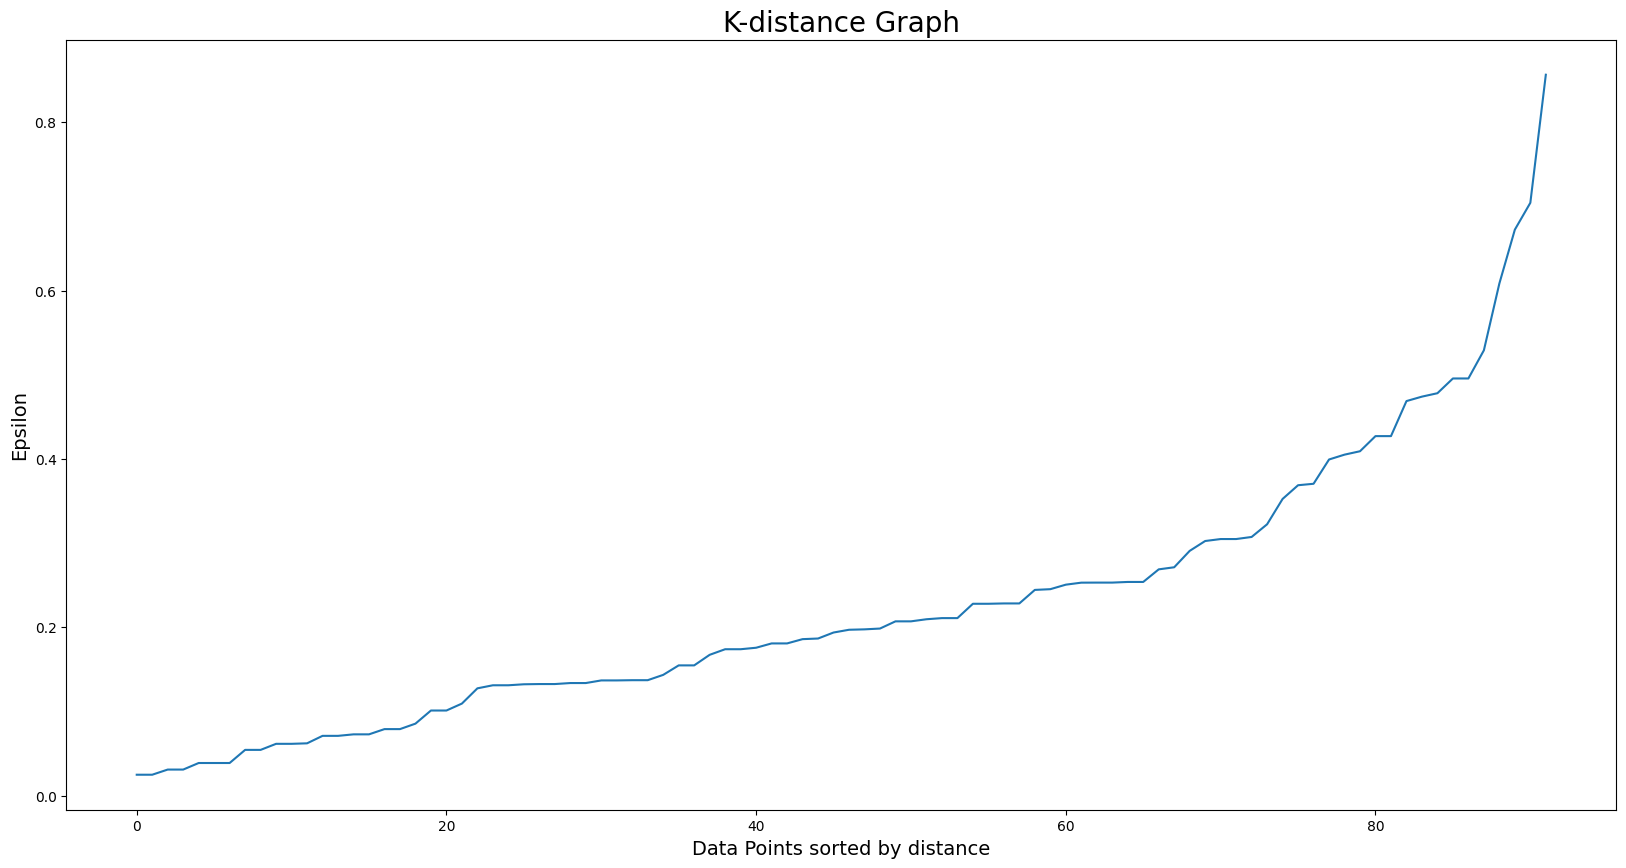

In [29]:
neigh = NearestNeighbors(n_neighbors=2).fit(rfm_df_scaled)
distances, indices = neigh.kneighbors(rfm_df_scaled)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [30]:
min_points = rfm_array_scaled.shape[1] + 1
dbscan_clustering = DBSCAN(min_samples=min_points, eps=0.5).fit(rfm_array_scaled)
customer_df = customer_df.assign(DBSCANLabel=dbscan_clustering.labels_)
rfm_df_scaled = rfm_df_scaled.assign(DBSCANLabel=dbscan_clustering.labels_)
rfm_df = rfm_df.assign(DBSCANLabel=dbscan_clustering.labels_)

fig = px.scatter_3d(
    data_frame=rfm_df,
    x= "RECENCY_days",
    y = "FREQUENCY_last_year",
    z= "MONETARY_last_year",
    title = "Relationship between RECENCY VS FREQUENCY VS MONETARY based on DBSCAN customer clusters",
    color = "DBSCANLabel",
    height=500
)
fig.update_traces(marker_size = 4)
fig.show()

customer_clusters_summarize = customer_df.groupby("DBSCANLabel")[["RECENCY_days", "FREQUENCY_last_year", "MONETARY_last_year"]].median()
customer_clusters_summarize.assign(CustomersCount=np.unique(dbscan_clustering.labels_, return_counts=True)[1])
# np.unique(dbscan_clustering.labels_, return_counts=True)[1]


,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,CustomersCount
DBSCANLabel,,,,
-1,48.0,3.0,100924.66,13
0,122.0,2.0,53300.20,26
1,194.0,1.0,34145.47,35
2,446.0,0.0,0.00,13
3,183.0,2.0,94117.26,5


## OPTICS ALgorithm

In [31]:
min_points = rfm_array_scaled.shape[1] + 1
optics_clustering = OPTICS(min_samples=min_points).fit(rfm_array_scaled)
customer_df = customer_df.assign(OPTICSLabel=optics_clustering.labels_)
rfm_df_scaled = rfm_df_scaled.assign(OPTICSLabel=optics_clustering.labels_)

fig = px.scatter_3d(
    data_frame=rfm_df_scaled,
    x= "RECENCY_days",
    y = "FREQUENCY_last_year",
    z= "MONETARY_last_year",
    title = "Relationship between RECENCY VS FREQUENCY VS MONETARY based on OPTICS customer cluster",
    color = "OPTICSLabel",
    height=500
)
fig.update_traces(marker_size = 4)
fig.show()

customer_clusters_summarize = customer_df.groupby("OPTICSLabel")[["RECENCY_days", "FREQUENCY_last_year", "MONETARY_last_year"]].median()
customer_clusters_summarize.assign(CustomersCount=np.unique(optics_clustering.labels_, return_counts=True)[1])
# np.unique(dbscan_clustering.labels_, return_counts=True)[1]


,RECENCY_days,FREQUENCY_last_year,MONETARY_last_year,CustomersCount
OPTICSLabel,,,,
-1,132.0,1.0,34145.470,43
0,183.0,2.0,92928.020,5
1,173.5,2.0,53944.865,6
2,46.0,2.0,54203.620,9
3,187.5,1.0,28538.195,12
4,197.0,1.0,55570.600,9
5,456.5,0.0,0.000,8
